In [1]:
data = "/content/drive/MyDrive/Social Computing/database.sqlite"
print("Using DB:", data)

Using DB: /content/drive/MyDrive/Social Computing/database.sqlite


In [2]:
import sqlite3, pandas as pd

pd.set_option("display.max_colwidth", 120)
conn = sqlite3.connect(data)

# Helper to run SQL and return a DataFrame
def q(sql, params=None):
    return pd.read_sql(sql, conn, params=params or {})

# Exercise 1.1: Reading the dataset

In [3]:
tables = q("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
tables

,name
0,comments
1,follows
2,posts
3,reactions
4,sqlite_sequence
5,users


In [4]:
from typing import Dict, Any

def example_values(table: str, n: int = 3) -> Dict[str, Any]:
    df = q(f"SELECT * FROM {table} LIMIT 200")
    out = {}
    for col in df.columns:

        ex = df[col].dropna().astype(str)
        out[col] = ex.iloc[0] if len(ex) else None
    return out

rows = []
for t in tables['name']:
    if t == 'sqlite_sequence':
        continue
    schema = q(f"PRAGMA table_info({t});")
    count = q(f"SELECT COUNT(*) AS n FROM {t};")['n'][0]
    examples = example_values(t)

    # expand one row per column for a descriptive table
    for _, r in schema.iterrows():
        rows.append({
            "table": t,
            "row_count": count,
            "column": r["name"],
            "type": r["type"],
            "not_null": bool(r["notnull"]),
            "default": r["dflt_value"],
            "pk": bool(r["pk"]),
            "example_value": examples.get(r["name"])
        })

schema_df = pd.DataFrame(rows)
schema_df.sort_values(["table", "pk"], ascending=[True, False]).reset_index(drop=True)

,table,row_count,column,type,not_null,default,pk,example_value
0,comments,5804,id,INTEGER,False,None,True,1
1,comments,5804,post_id,INTEGER,True,None,False,1963
2,comments,5804,user_id,INTEGER,True,None,False,55
3,comments,5804,content,TEXT,True,None,False,"Haha, I bet your neighbors are either loving or hating you right now! Crank it up and see if you can get a dance par..."
4,comments,5804,created_at,TIMESTAMP,True,CURRENT_TIMESTAMP,False,2022-12-04 02:36:15
5,follows,7225,follower_id,INT,True,None,False,12
6,follows,7225,followed_id,INT,True,None,False,1
7,posts,1303,id,INTEGER,False,None,True,1718
8,posts,1303,user_id,INTEGER,True,None,False,10
9,posts,1303,content,TEXT,True,None,False,Just had the most ridiculous encounter with a cat in Shibuya. It hissed like I was invading its turf! #CatWhisperer ...


# Exercise 1.2: Lurkers

In [5]:
lurkers_sql = """
SELECT COUNT(*) AS lurkers_count
FROM users u
WHERE u.id NOT IN (SELECT DISTINCT user_id FROM posts)
  AND u.id NOT IN (SELECT DISTINCT user_id FROM comments)
  AND u.id NOT IN (SELECT DISTINCT user_id FROM reactions);
"""
lurkers_count = q(lurkers_sql)['lurkers_count'][0]
lurkers_count


np.int64(55)

In [6]:
lurkers_list_sql = """
SELECT u.id, u.username
FROM users u
WHERE u.id NOT IN (SELECT DISTINCT user_id FROM posts)
  AND u.id NOT IN (SELECT DISTINCT user_id FROM comments)
  AND u.id NOT IN (SELECT DISTINCT user_id FROM reactions)
ORDER BY u.id;
"""
lurkers_df = q(lurkers_list_sql)
lurkers_df.head(20)

,id,username
0,474,starry_night
1,475,breezyday22
2,476,wanderlust89
3,477,tech_savvy
4,478,coffee_lover
5,479,bookworm77
6,480,traveler_guy
7,481,sunshine_day
8,482,nightowl22
9,483,music_lover


# Exercise 1.3: Influencers

## I think here Engagement means (comments + reactions) received on a user’s posts.

In [7]:
influencers_sql = """
WITH post_eng AS (
  SELECT p.user_id,
         COUNT(DISTINCT c.id) AS comment_count,
         COUNT(DISTINCT r.id) AS reaction_count,
         (COUNT(DISTINCT c.id) + COUNT(DISTINCT r.id)) AS total_engagement
  FROM posts p
  LEFT JOIN comments c ON c.post_id = p.id
  LEFT JOIN reactions r ON r.post_id = p.id
  GROUP BY p.user_id
)
SELECT u.id AS user_id, u.username, comment_count, reaction_count, total_engagement
FROM post_eng pe
JOIN users u ON u.id = pe.user_id
ORDER BY total_engagement DESC
LIMIT 5;
"""
top5_influencers = q(influencers_sql)
top5_influencers


,user_id,username,comment_count,reaction_count,total_engagement
0,54,WinterWolf,179,267,446
1,65,PinkPanther,152,234,386
2,94,PinkPetal,137,246,383
3,81,GoldenDreams,149,217,366
4,30,WildHorse,157,196,353


# Exercise 1.4: Spammers

In [8]:
spammers_detail_sql = """
WITH all_texts AS (
  SELECT user_id, content FROM posts
  UNION ALL
  SELECT user_id, content FROM comments
),
repeats AS (
  SELECT user_id, content, COUNT(*) AS times_shared
  FROM all_texts
  GROUP BY user_id, content
  HAVING COUNT(*) >= 3
)
SELECT u.id AS user_id, u.username, r.content, r.times_shared
FROM repeats r
JOIN users u ON u.id = r.user_id
ORDER BY r.times_shared DESC, u.id ASC;
"""
spammers_detail = q(spammers_detail_sql)
spammers_detail.head(20)


,user_id,username,content,times_shared
0,513,night_owl,? Mega Giveaway Alert! ? Follow all accounts we’re following and DM us to enter! ? #Freebie,8
1,530,coding_whiz,Top 10 gadgets of 2025 – All available here: bestbuystuff.click/top10,8
2,513,night_owl,?FLASH GIVEAWAY? Click the link in our bio to claim your PS5! Only 100 units left! #giveaway #win,7
3,533,eco_warrior,"Not gonna lie, I was skeptical at first. But after tagging three friends and waiting 24 hours, I actually got my fre...",7
4,521,history_buff,A lot of you asked what helped me drop 5kg in a month—this tea really works! Here’s my referral link: fittearesults[...,5
5,521,history_buff,Best way to clean your sneakers ? snag yours here ➡️ whitelabelshop.biz/sneakerclean,5
6,521,history_buff,Mood: me refreshing for likes every 30 seconds #relatable #socialmediaproblems #algorithmwarrior #realonesknow #lmaooo,5
7,524,yoga_yogi,"I couldn’t believe it! I just entered this giveaway and actually won a brand-new iPhone 15. Thought it was fake, but...",5
8,530,coding_whiz,Shocking! #lol #weekend #coffee #bookstagram #design #artist #blogger #aesthetic,5
9,513,night_owl,?FREE VACATION? Tag a friend you’d take to Bali! Winners picked tonight! #TravelGiveaway,4


In [9]:
spammers_summary_sql = """
WITH all_texts AS (
  SELECT user_id, content FROM posts
  UNION ALL
  SELECT user_id, content FROM comments
),
repeats AS (
  SELECT user_id, content, COUNT(*) AS times_shared
  FROM all_texts
  GROUP BY user_id, content
  HAVING COUNT(*) >= 3
)
SELECT u.id AS user_id, u.username,
       COUNT(*) AS distinct_repeated_texts,
       SUM(times_shared) AS total_repeated_instances
FROM repeats r
JOIN users u ON u.id = r.user_id
GROUP BY u.id, u.username
ORDER BY total_repeated_instances DESC, distinct_repeated_texts DESC;
"""
spammers_summary = q(spammers_summary_sql)
spammers_summary


,user_id,username,distinct_repeated_texts,total_repeated_instances
0,513,night_owl,5,26
1,521,history_buff,5,22
2,530,coding_whiz,3,16
3,533,eco_warrior,3,14
4,524,yoga_yogi,2,8


# Task 2.1: Growth and Capacity Planning for servers

In [29]:
import sqlite3, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [21]:
sql = """
WITH all_events AS (
  SELECT date(created_at) as dt FROM posts
  UNION ALL
  SELECT date(created_at) FROM comments
)
SELECT dt, COUNT(*) as activity
FROM all_events
GROUP BY dt
ORDER BY dt;
"""
daily = pd.read_sql(sql, conn, parse_dates=["dt"])


In [22]:
# Latest day = "today"
today = daily["dt"].max()
current_year = today.year

In [23]:
# Yearly totals + current annualized
daily["year"] = daily["dt"].dt.year
yearly = daily.groupby("year")["activity"].sum().reset_index()

# Current year annualized
start_of_year = pd.Timestamp(f"{current_year}-01-01")
ytd = daily[daily["dt"] >= start_of_year]
days_elapsed = (today - start_of_year).days + 1
annualized_current = ytd["activity"].sum() / days_elapsed * 365


In [24]:
# Growth factor (recent YoY average)
val_2023 = yearly.loc[yearly["year"] == 2023, "activity"]
val_2024 = yearly.loc[yearly["year"] == 2024, "activity"]

factors = []
if not val_2023.empty and not val_2024.empty and val_2023.iloc[0] > 0:
    factors.append(val_2024.iloc[0] / val_2023.iloc[0])
if not val_2024.empty and val_2024.iloc[0] > 0:
    factors.append(annualized_current / val_2024.iloc[0])

growth = np.prod(factors) ** (1/len(factors)) if factors else 1.0


In [25]:
# Forecasting next 3 years
forecast = []
for i in range(1, 4):
    yr = current_year + i
    act = annualized_current * (growth ** i)
    forecast.append((yr, act))
forecast = pd.DataFrame(forecast, columns=["year", "forecast_activity"])

In [26]:
# Converting to servers
activity_per_server = annualized_current / 16  # 16 servers = 100% today
forecast["servers"] = (forecast["forecast_activity"] / activity_per_server).apply(math.ceil)
peak = forecast["servers"].max()
target = math.ceil(peak * 1.2)
additional = target - 16


In [27]:

print("Current annualized activity:", round(annualized_current))
print("Growth factor per year:", round(growth, 2))
print("\nForecast:")
print(forecast)
print("\nPeak servers needed:", peak)
print("Target servers with +20% redundancy:", target)
print("Additional servers to rent now:", additional)


Current annualized activity: 3736
Growth factor per year: 1.78

Forecast:
   year  forecast_activity  servers
0  2026        6639.140659       29
1  2027       11798.340115       51
2  2028       20966.693828       90

Peak servers needed: 90
Target servers with +20% redundancy: 108
Additional servers to rent now: 92


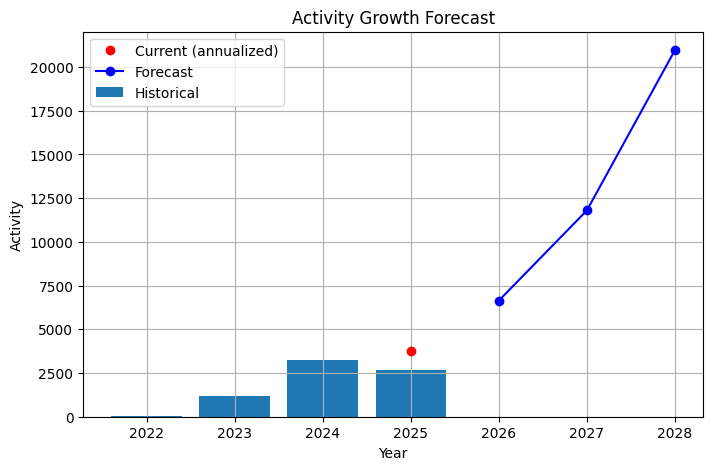

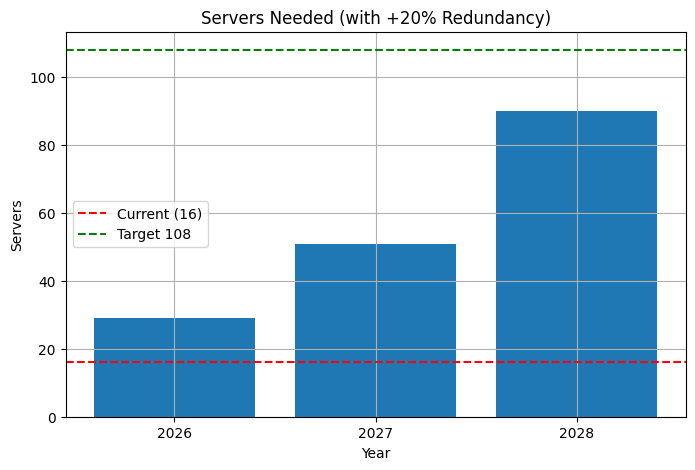

In [28]:
# --- 8) Plot ---
plt.figure(figsize=(8,5))
plt.bar(yearly["year"].astype(str), yearly["activity"], label="Historical")
plt.plot([str(current_year)], [annualized_current], "ro", label="Current (annualized)")
plt.plot(forecast["year"].astype(str), forecast["forecast_activity"], "bo-", label="Forecast")
plt.title("Activity Growth Forecast")
plt.xlabel("Year"); plt.ylabel("Activity")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.bar(forecast["year"].astype(str), forecast["servers"])
plt.axhline(y=16, color="r", linestyle="--", label="Current (16)")
plt.axhline(y=target, color="g", linestyle="--", label=f"Target {target}")
plt.title("Servers Needed (with +20% Redundancy)")
plt.xlabel("Year"); plt.ylabel("Servers")
plt.legend(); plt.grid(True); plt.show()

# Exercise 2.2: Virality

In [30]:
# Firstly I have to compute engagement per post whic is the summation of comments and reactions.
sql = """
WITH engagement AS (
  SELECT p.id AS post_id, p.user_id,
         COUNT(DISTINCT c.id) AS comments,
         COUNT(DISTINCT r.id) AS reactions,
         (COUNT(DISTINCT c.id) + COUNT(DISTINCT r.id)) AS total_engagement
  FROM posts p
  LEFT JOIN comments c ON c.post_id = p.id
  LEFT JOIN reactions r ON r.post_id = p.id
  GROUP BY p.id, p.user_id
)
SELECT e.post_id, u.username, e.user_id,
       e.comments, e.reactions, e.total_engagement,
       p.content
FROM engagement e
JOIN posts p ON p.id = e.post_id
JOIN users u ON u.id = e.user_id
ORDER BY e.total_engagement DESC, e.comments DESC, e.reactions DESC
LIMIT 3;
"""
top3 = pd.read_sql(sql, conn)
display(top3)

,post_id,username,user_id,comments,reactions,total_engagement,content
0,2351,PinkPetal,94,62,139,201,Just finished a DIY project turning old pallets into a garden bench. It turned out better than I expected! ? #Upcycling
1,2813,eagle_eric,135,82,103,185,"Recently, I've been reflecting on the importance of kindness in everyday interactions. We all have the power to make..."
2,2195,BlueOcean,78,45,133,178,"Cooked up a vegan feast last night and managed to not burn anything! Progress, not perfection. #VeganLife #ChefInThe..."


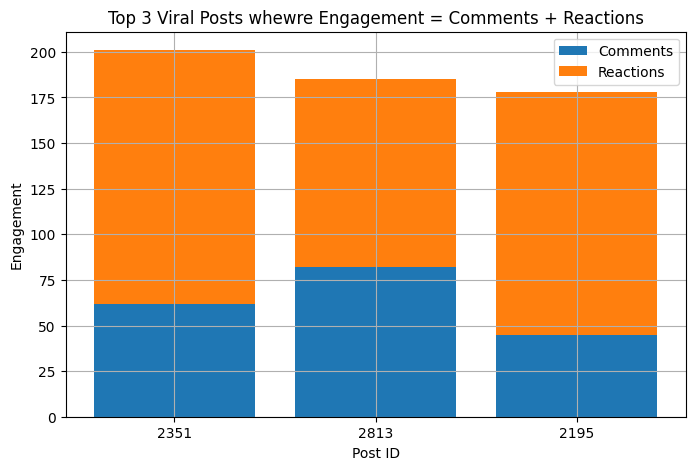

In [32]:
plt.figure(figsize=(8,5))
x = top3["post_id"].astype(str)
plt.bar(x, top3["comments"], label="Comments")
plt.bar(x, top3["reactions"], bottom=top3["comments"], label="Reactions")
plt.title("Top 3 Viral Posts whewre Engagement = Comments + Reactions")
plt.xlabel("Post ID")
plt.ylabel("Engagement")
plt.legend()
plt.grid(True)
plt.show()

# Exercise 2.3: Content Lifecycle

In [35]:
# Computing first & last comment times per post
sql = """
WITH comment_times AS (
  SELECT p.id AS post_id, p.created_at AS post_time,
         MIN(c.created_at) AS first_comment_time,
         MAX(c.created_at) AS last_comment_time
  FROM posts p
  LEFT JOIN comments c ON p.id = c.post_id
  GROUP BY p.id
)
SELECT post_id, post_time,
       first_comment_time,
       last_comment_time,
       julianday(first_comment_time) - julianday(post_time) AS days_to_first,
       julianday(last_comment_time) - julianday(post_time) AS days_to_last
FROM comment_times
WHERE first_comment_time IS NOT NULL;  -- only posts with at least one comment
"""
df = pd.read_sql(sql, conn, parse_dates=["post_time","first_comment_time","last_comment_time"])
avg_first = df["days_to_first"].mean()
avg_last = df["days_to_last"].mean()


In [36]:
print(f"Average time to first engagement: {avg_first:.2f} days")
print(f"Average time to last engagement:  {avg_last:.2f} days")

Average time to first engagement: 1.88 days
Average time to last engagement:  5.79 days


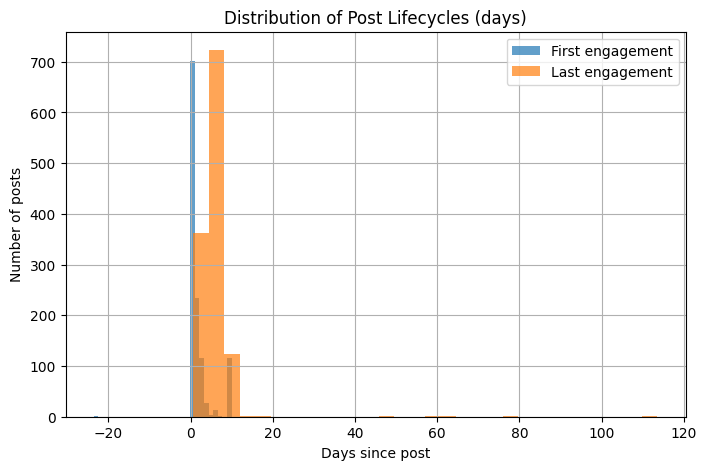

In [37]:
plt.figure(figsize=(8,5))
plt.hist(df["days_to_first"], bins=30, alpha=0.7, label="First engagement")
plt.hist(df["days_to_last"], bins=30, alpha=0.7, label="Last engagement")
plt.title("Distribution of Post Lifecycles (days)")
plt.xlabel("Days since post")
plt.ylabel("Number of posts")
plt.legend()
plt.grid(True)
plt.show()

# Exercise 2.4: Connections

In [38]:
# SQL: engagement actions (comments + reactions)
sql = """
WITH comment_engagement AS (
  SELECT c.user_id AS engager, p.user_id AS author, COUNT(*) AS actions
  FROM comments c
  JOIN posts p ON c.post_id = p.id
  GROUP BY c.user_id, p.user_id
),
reaction_engagement AS (
  SELECT r.user_id AS engager, p.user_id AS author, COUNT(*) AS actions
  FROM reactions r
  JOIN posts p ON r.post_id = p.id
  GROUP BY r.user_id, p.user_id
),
all_engagement AS (
  SELECT engager, author, SUM(actions) AS total_actions
  FROM (
    SELECT * FROM comment_engagement
    UNION ALL
    SELECT * FROM reaction_engagement
  )
  GROUP BY engager, author
),
pairwise AS (
  -- collapse A->B and B->A into an unordered pair (user1,user2)
  SELECT
    CASE WHEN e1.engager < e1.author THEN e1.engager ELSE e1.author END AS user1,
    CASE WHEN e1.engager < e1.author THEN e1.author ELSE e1.engager END AS user2,
    (e1.total_actions + COALESCE(e2.total_actions,0)) AS mutual_engagement
  FROM all_engagement e1
  LEFT JOIN all_engagement e2
    ON e1.engager = e2.author AND e1.author = e2.engager
  WHERE e1.engager < e1.author
)
SELECT u1.id AS user1_id, u1.username AS user1,
       u2.id AS user2_id, u2.username AS user2,
       p.mutual_engagement
FROM pairwise p
JOIN users u1 ON u1.id = p.user1
JOIN users u2 ON u2.id = p.user2
ORDER BY p.mutual_engagement DESC
LIMIT 3;
"""
top3 = pd.read_sql(sql, conn)
display(top3)

,user1_id,user1,user2_id,user2,mutual_engagement
0,38,DancingDolphin,88,SilverMoon,16
1,9,userInBlack,51,TigerEye,13
2,13,StarGazer,54,WinterWolf,13


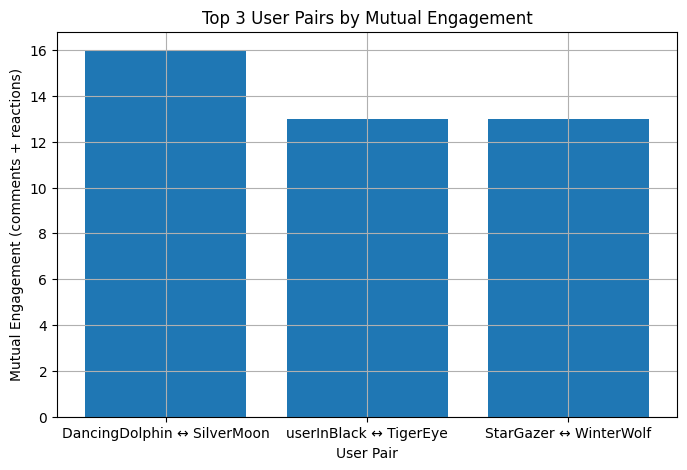

In [39]:
plt.figure(figsize=(8,5))
labels = [f"{a} ↔ {b}" for a,b in zip(top3["user1"], top3["user2"])]
plt.bar(labels, top3["mutual_engagement"])
plt.title("Top 3 User Pairs by Mutual Engagement")
plt.xlabel("User Pair")
plt.ylabel("Mutual Engagement (comments + reactions)")
plt.grid(True)
plt.show()
